# Reading O5 Catalog

In [1]:
import os
import subprocess
import yaml

from astropy.io import fits
import numpy as np
import pandas as pd
import glob
from tqdm import tqdm
import random
from scipy.stats import norm
import glob
from pathlib import Path

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
sns.set()

# Opening a file

In [11]:
# g = fits.open(f)
g = fits.open("/Users/jarred/Downloads/TeV Catalog O5/catO5_100.fits")

In [12]:
g.info()

Filename: /Users/jarred/Downloads/TeV Catalog O5/catO5_100.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      13   ()      
  1  ENERGIES      1 BinTableHDU     13   41R x 1C   [E]   
  2  TIMES         1 BinTableHDU     17   70R x 2C   [E, E]   
  3  SPECTRA       1 BinTableHDU     92   70R x 41C   [D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   


### Units
- time [s]
- energy [GeV]
- spectral flux [ph/cm2/s/GeV]


In [24]:
g[0].hedaer

AttributeError: 'PrimaryHDU' object has no attribute 'hedaer'

In [117]:
d = g[3].data

In [118]:
start_times = [i[0] for i in g[2].data]

def get_spec(time_bin, data):
    
    return [i[time_bin] for i in data]

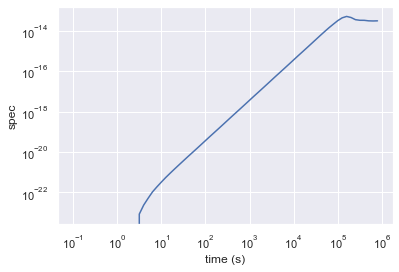

In [119]:
plt.loglog(start_times, get_spec(0, g[3].data))
plt.xlabel("time (s)")
plt.ylabel("spec")
plt.show()

# Extracting info from files

In [199]:
g[3].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  328 / length of dimension 1                          
NAXIS2  =                   70 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   41 / number of table fields                         
UNITS   = 'ph/cm2/s/GeV'                                                        
EXTNAME = 'SPECTRA '           / extension name                                 
TTYPE1  = 'col0    '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'col1    '        

In [121]:
p = Path(f)

In [122]:
p.stem.strip("catO?5_")

'0'

In [123]:
info = {}

for gw in glob.glob(fp + "*.fits"):
    
    try:
        gw_id = int(Path(gw).stem[6:])
    except ValueError as e:
        
        print(gw)
        raise e
    
    g = fits.open(gw)
    
    h = g[0].header
    
    info[gw_id] = {
        "event_id": gw_id,
        "long": h["LONG"],
        "lat": h["LAT"],
        "eiso": h["EISO"],
        "dist": h["DISTANCE"],
        "angle": h["ANGLE"],
    }
    
    g.close()

In [124]:
events = pd.DataFrame.from_dict(info, orient="index")

## Read in times

In [125]:
times = pd.read_csv(
    "../GammaCatalog_O5/times.txt", 
    sep="\t", 
    names=["event_id", "time_utc"], 
    parse_dates=["time_utc"],
    skiprows=1
) 

In [126]:
events = pd.merge(events, times, on="event_id").set_index("event_id").sort_index()

In [127]:
events.to_csv("../GammaCatalog_O5/events.csv")

# Interacting with GW Toy

In [3]:
import sys
sys.path.append("..")

In [4]:
from gravitational_wave_toy import GWToyV5 as GW

In [73]:
sens = GW.Sensitivity(
    "/Users/jarred/Documents/grbsens/notebooks/grbsens_output/no_ebl/grbsens_results/grbsens-5.0sigma_t1s-t16384s_irf-South_z20_0.5h.txt",
    min_energy=0.3,     # as determined by the range of the IRFs
    max_energy=10000,
)

In [176]:
grb = GW.GRB("../GammaCatalog_O5/catO5_24.fits")

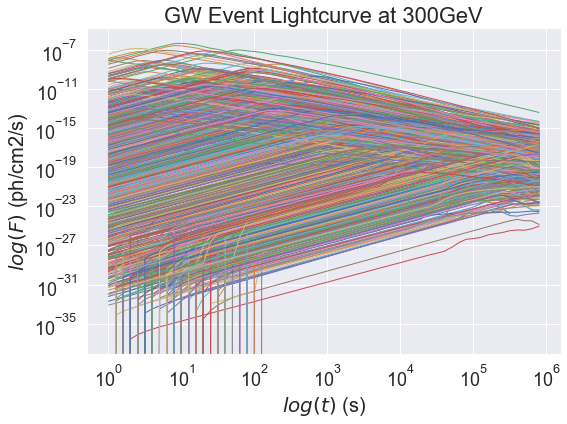

In [224]:
fig, ax = plt.subplots(figsize=(8,6))

for i in range(1000):
    grb = GW.GRB(f"../GammaCatalog_O5/catO5_{i+1}.fits")
    ax.loglog(grb.time[10:], grb.get_flux(300)[10:], linewidth=1)

ax.set_title("GW Event Lightcurve at 300GeV", size=22)
ax.set_xlabel("$log(t)$ (s)", size=20)
ax.set_ylabel("$log(F)$ (ph/cm2/s)", size=20)
ax.tick_params(axis='both', which='major', labelsize=18)
fig.tight_layout()

fig.savefig("/Users/jarred/Downloads/example_GW_lightcurve.png")

In [135]:
grb.observe(sensitivity=sens, start_time=600, target_precision=0.1)

{'filepath': '../GammaCatalog_O5/catO5_100.fits',
 'min_energy': 0.3,
 'max_energy': 10000,
 'seen': False,
 'obs_time': -1,
 'start_time': 3600,
 'end_time': -1,
 'error_message': '',
 'long': 6.155,
 'lat': -1.0,
 'eiso': 5.73e+47,
 'dist': 1240000.0,
 'angle': 54.081}

In [32]:
# OR

GW.observe_grb(
    "../GammaCatalog_O5/catO5_100.fits",
    sensitivity=s,
    start_time=7200,
)

{'filepath': '../GammaCatalog_O5/catO5_1.fits',
 'min_energy': 0.3,
 'max_energy': 10000,
 'seen': True,
 'obs_time': 6,
 'start_time': 7200,
 'end_time': 7206,
 'error_message': '',
 'long': 1.666,
 'lat': -0.917,
 'eiso': 3.08e+50,
 'dist': 1280000.0,
 'angle': 28.794}